In [0]:
import os
import sys

In [2]:
# Google ドライブをマウントするには、このセルを実行してください。
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
base_dir = "/content/drive//My Drive/object_d".replace('/', os.sep)

In [0]:
sys.path.append(base_dir)

In [5]:
import tensorflow as tf
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

Using TensorFlow backend.


##1.Set the model configuration parameters

In [0]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

##2.Build or load the model
  
Create a new model and load trained VGG-16 weights into it (or trained SSD weights)

In [7]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
weights_path = os.path.join(base_dir,'weight/weight.h5')

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=sgd, loss=ssd_loss.compute_loss)

W0701 23:57:39.750155 140119722407808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0701 23:57:39.752058 140119722407808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0701 23:57:39.802178 140119722407808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 23:57:39.805887 140119722407808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W070

##3.Set up the data genarators for the training

In [8]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# TODO: Set the paths to the datasets here.

# The directories that contain the images.
image_dir = os.path.join(base_dir, 'cut-PascalVOC-export/JPEGImages')

# The directories that contain the annotations.
annotations_dir = os.path.join(base_dir, 'cut-PascalVOC-export/Annotations')

# The paths to the image sets.
nut_train_filename = os.path.join(base_dir, 'cut-PascalVOC-export/ImageSets/Main/nut_train.txt')
washer_train_filename = os.path.join(base_dir, 'cut-PascalVOC-export/ImageSets/Main/washer_train.txt')
nut_val_filename = os.path.join(base_dir, 'cut-PascalVOC-export/ImageSets/Main/nut_val.txt')
washer_val_filename = os.path.join(base_dir, 'cut-PascalVOC-export/ImageSets/Main/washer_val.txt')

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'nut', 'washer']

train_dataset.parse_xml(images_dirs=[image_dir],
                        image_set_filenames=[nut_train_filename,
                                             washer_train_filename],
                        annotations_dirs=[annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[image_dir],
                      image_set_filenames=[nut_val_filename,
                                           washer_val_filename],
                      annotations_dirs=[annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

train_dataset.create_hdf5_dataset(file_path='train_dataset.h5',
                                  resize=False,
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='val_dataset.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)

Creating HDF5 dataset: 100%|██████████| 14/14 [00:06<00:00,  1.90it/s]


In [9]:
# 3: Set the batch size.

batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	    52
Number of images in the validation dataset:	    14


##4.Set the remaining training parameters

In [0]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [0]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='ssd300_train_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='ssd300_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

##5.Train

In [12]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 100
steps_per_epoch = 3

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
3/3 [==============================] - 48s 16s/step - loss: 9.1856 - val_loss: 4.9597

Epoch 00001: val_loss improved from inf to 4.95969, saving model to ssd300_train_epoch-01_loss-9.0814_val_loss-4.9597.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
3/3 [==============================] - 23s 8s/step - loss: 5.1044 - val_loss: 3.8881

Epoch 00002: val_loss improved from 4.95969 to 3.88815, saving model to ssd300_train_epoch-02_loss-5.1609_val_loss-3.8881.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
3/3 [==============================] - 20s 7s/step - loss: 4.6233 - val_loss: 3.9369

Epoch 00003: val_loss did not improve from 3.88815
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
3/3 [==============================] - 20s 7s/step - loss: 4.2625 - val_loss: 3.4546

Epoch 00004: val_loss improved from 3.

##6.Make predictions

In [0]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [0]:
# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: /content/drive//My Drive/object_d/cut-PascalVOC-export/JPEGImages/nut_washer.mp4#t=36.jpg

Ground truth boxes:

[[  1 458 296 638 465]
 [  2 750 223 919 354]
 [  1 516   0 658 158]]


In [0]:
# 3: Make predictions.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model = load_model('ssd300_train_epoch-88_loss-2.4398_val_loss-2.4162.h5', custom_objects={'AnchorBoxes': AnchorBoxes,
                                                           'L2Normalization': L2Normalization,
                                                           'compute_loss': ssd_loss.compute_loss})
y_pred = model.predict(batch_images)

In [0]:
# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

In [0]:
# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     1.   497.    -2.   655.   147.  ]
 [  1.     1.   458.   289.   626.   460.  ]
 [  2.     0.97 744.   221.   907.   347.  ]]


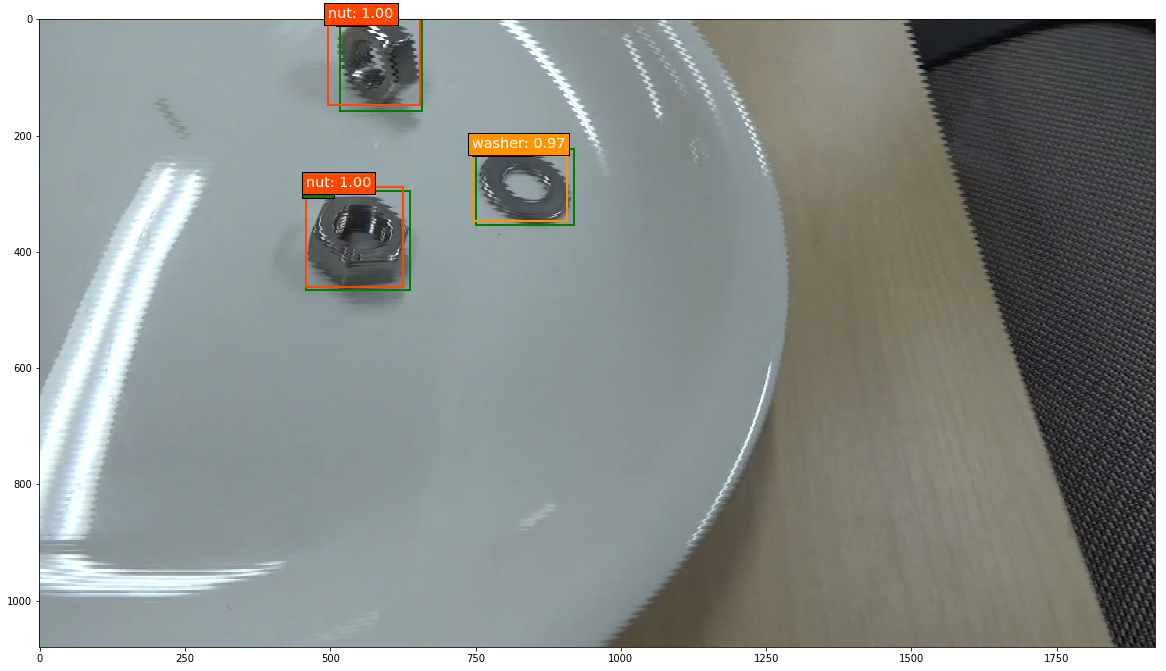

In [0]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'nut','washer']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [0]:
tf.keras.models.save_model(
    model,
    'mymodel.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None
)

ValueError: ignored